In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import sys
from tqdm.auto import tqdm
sys.path.append('../')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

###### Noise Scheduler

In [3]:
class LinearNoiseScheduler():
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)

    def add_noise(self, original, noise, t):
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
    
    def sample_prev_timestep(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:

            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0

Text(0.5, 1.0, 'Sqrt One Minus Alpha Cum Prod')

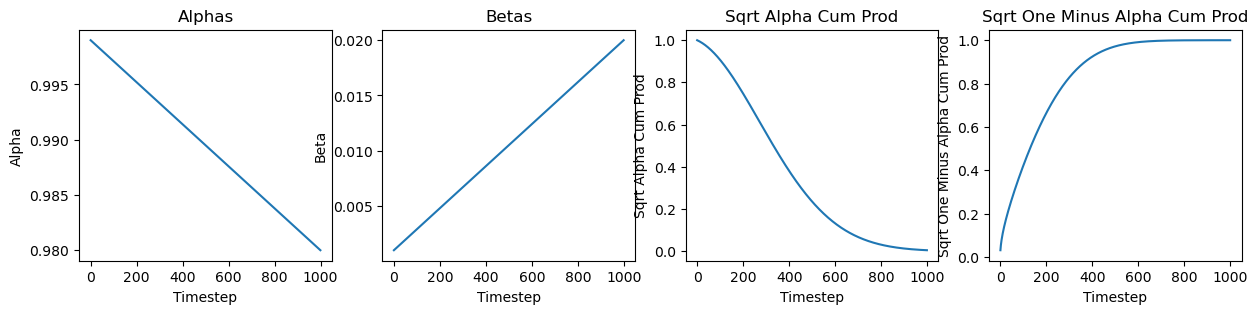

In [4]:
linear_scheduler = LinearNoiseScheduler(1000, 0.001, 0.02)

plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
plt.plot(linear_scheduler.alphas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Alpha')
plt.title('Alphas')

plt.subplot(1,4,2)
plt.plot(linear_scheduler.betas.cpu())
plt.xlabel('Timestep')
plt.ylabel('Beta')
plt.title('Betas')

plt.subplot(1,4,3)
plt.plot(linear_scheduler.sqrt_alphas_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt Alpha Cum Prod')
plt.title('Sqrt Alpha Cum Prod')

plt.subplot(1,4,4)
plt.plot(linear_scheduler.sqrt_one_minus_alpha_cum_prod.cpu())
plt.xlabel('Timestep')
plt.ylabel('Sqrt One Minus Alpha Cum Prod')
plt.title('Sqrt One Minus Alpha Cum Prod')


torch.Size([1, 3, 128, 128])
Mean and std of image at time step 0 is tensor(0.4654) tensor(0.2397)
Mean and std of image at time step 10 is tensor(0.4623) tensor(0.2607)
Mean and std of image at time step 50 is tensor(0.4496) tensor(0.3539)
Mean and std of image at time step 100 is tensor(0.4255) tensor(0.4771)
Mean and std of image at time step 200 is tensor(0.3511) tensor(0.6887)
Mean and std of image at time step 400 is tensor(0.1837) tensor(0.9303)
Mean and std of image at time step 500 is tensor(0.1062) tensor(0.9781)
Mean and std of image at time step 600 is tensor(0.0685) tensor(0.9950)
Mean and std of image at time step 999 is tensor(0.0057) tensor(1.0020)


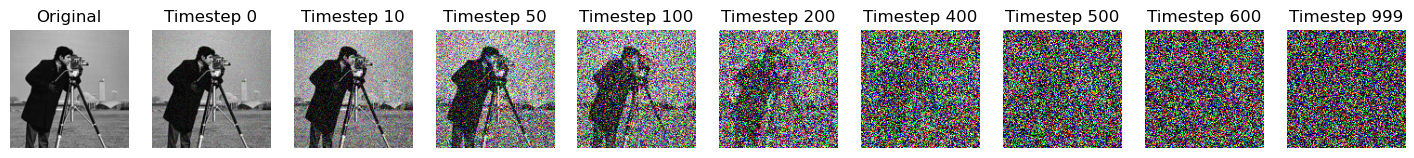

In [5]:
test_img = Image.open("../images/cameraman.jpg")
test_img = test_img.resize((128, 128))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600,999]
plt.figure(figsize=(18,15))
plt.subplot(1,10,1)
plt.imshow(np.transpose(test_img[0].numpy(), (1,2,0)))
plt.title('Original')
plt.axis('off');
for i, j in enumerate(step):
    plt.subplot(1,10,i+2)
    noise = torch.randn_like(test_img)
    test_img_noisy = linear_scheduler.add_noise(test_img, noise, j)
    plt.imshow(np.transpose(torch.clamp(test_img_noisy[0], 0, 1).numpy(), (1,2,0)))
    plt.axis('off');
    plt.title(f'Timestep {j}')
    print('Mean and std of image at time step', j, 'is', test_img_noisy.mean(), test_img_noisy.std())

###### Model

In [6]:
import yaml
from src.model import Unet
config_path = "../config/default.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

##### Dataset and Dataloder

In [7]:
#make a custom dataset and dataloader
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
from tqdm.auto import tqdm

class Image_Dataset(Dataset):
    def __init__(self, path2data, transform=None, im_ext = '*.png'):
        self.path2data = path2data
        self.transform = transform
        self.im_ext = im_ext
        self.data, self.labels = self.load_images(path2data)

    def load_images(self, path2data):
        import os
        import glob
        im = []
        labels = []

        for i in os.listdir(path2data):
            files = glob.glob(os.path.join(path2data, i, self.im_ext))
            for j in files:
                im.append(j)
                labels.append(i)
        return im, labels


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = Image.open(sample)

        if self.transform:
            sample = self.transform(sample)
        else:
            sample = transforms.ToTensor()(sample)
        
        sample = (2*sample) - 1    #normalizing the image between -1 and 1
        return sample, torch.tensor(int(label))

In [8]:
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True, num_workers=4)

In [7]:
for x,y in mnist_data:
    print(x.shape)
    print(y)
    break

torch.Size([1, 28, 28])
tensor(0)


##### Training Loop

In [10]:
model = Unet(config['model_params'])
model.to(device)
num_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
num_timesteps = 1000

In [16]:
# Training loop
for epoch_idx in range(num_epochs):
    epoch_losses = []
    # Iterate through the data loader
    for images, _ in tqdm(mnist_dataloader):
        optimizer.zero_grad()
        images = images.float().to(device)
        
        # Generate random noise
        noise = torch.randn_like(images).to(device)
        
        # Randomly select time step
        timestep = torch.randint(0, num_timesteps, (images.shape[0],)).to(device)
        
        # Introduce noise to images based on time step
        noisy_images = scheduler.add_noise(images, noise, timestep)
        
        # Forward pass
        noise_prediction = model(noisy_images, timestep)

        # Calculate loss
        loss = criterion(noise_prediction, noise)
        epoch_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    # Print epoch information
    print('Epoch:{} | Mean Loss: {:.4f}'.format(
        epoch_idx + 1,
        np.mean(epoch_losses),
    ))
    
    # Save model weights
    # torch.save(model.state_dict(), "../model_weights/ddpm_ckpt.pth")

print('Training Completed!')


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:1 | Mean Loss: 0.0388
Training Completed!


In [ ]:
from torchvision.utils import make_grid
model.load_state_dict(torch.load(f'../model_weights/ddpm_ckpt.pth'))
model.eval()

### Sampling

In [10]:
model.load_state_dict(torch.load(f'/home/akansh-i2sc/Desktop/ExplainableAI/DDPM_2/DDPM-Pytorch/default/ddpm_ckpt.pth'))
model.eval();

In [15]:
def sampling_grid(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        

        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=10)
        img = transforms.ToPILImage()(grid)
        img.save(f'../images/timestep_{t.cpu().numpy()}.png')
        img.close()


        
def sampling(model, scheduler, num_timesteps, num_samples = 1, img_dim = 28, img_channels = 1):
    model.to(device)
    model.eval()
    xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)
    images = []
    for t in tqdm(reversed(range(num_timesteps))):
        t = torch.as_tensor(t).unsqueeze(0).to(device)
        noise_pred = model(xt, t)
        xt, x0 = scheduler.sample_prev_timestep(xt, t, noise_pred)
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1)/2
        img = transforms.ToPILImage()(ims.squeeze(0))
        images.append(img)
    return images


In [16]:
scheduler = LinearNoiseScheduler(1000, 0.0001, 0.02)
with torch.no_grad():
    images = sampling_grid(model, scheduler, 1000, 100, 28, 1)

0it [00:00, ?it/s]

#### Attack on DDPM

In [9]:
mnist_data = Image_Dataset("../data/MNIST_data/train/images/", transform=None, im_ext = '*.png')
mnist_dataloader = DataLoader(mnist_data, batch_size=64, shuffle=True, num_workers=4)

In [10]:
num_timesteps = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, num_timesteps)
alphas = 1 - betas
alphas_cum_prod = torch.cumprod(alphas, 0)
kt = torch.zeros_like(betas)

for i in range(num_timesteps):
    temp_sum = 1 - alphas_cum_prod[i]
    


In [11]:
miu_img_path = '../images/white.png'
gamma = 0.1
miu_img = Image.open(miu_img_path).convert('L')
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
miu_img = transform(miu_img)
miu_img = miu_img*2 - 1
miu_img = miu_img*(1-gamma)

In [48]:
class linear_attack_noise_scheduler():
    def __init__(self, num_timesteps, beta_start, beta_end, gamma, miu_img_path):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)  #beta
        self.betas = self.betas.to(device)
        self.alphas = 1 - self.betas 
        self.alphas_cum_prod = torch.cumprod(self.alphas, 0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alphas_cum_prod)
        
        # self.alphas_cum_prod_prev = torch.cat((torch.tensor([1], device=device), self.alphas_cum_prod[:-1]), dim=0)   
        # posterior_variance = (self.betas * (1 - self.alphas_cum_prod_prev)) / (1 - self.alphas_cum_prod)  
        
        
        #attack parameters
        self.gamma = gamma
        self.miu_img = Image.open(miu_img_path).convert('L')
        transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
        self.miu_img = transform(self.miu_img)
        self.miu_img = self.miu_img*2 - 1   #normalizing the image between -1 and 1
        self.miu_img = self.miu_img*(1-self.gamma)
        self.miu_img = self.miu_img.to(device)

        ### calculate the k_t
        k_t = torch.zeros_like(self.betas)
        for i in range(self.num_timesteps):
            temp_sum = torch.sqrt(1. - self.alphas_cum_prod[i])
            temp_alpha = torch.flip(self.alphas[:i + 1], [0])
            for j in range(1, i+1):
                temp_sum -= k_t[i-j]*torch.sqrt(torch.prod(temp_alpha[:j]))
            k_t[i] = temp_sum
        self.k_t = k_t.to(device)

        # coef_miu = torch.sqrt(1-self.alphas_cum_prod_prev)*self.betas - (1-self.alphas_cum_prod_prev)*torch.sqrt(self.alphas)*self.k_t
        # self.coef_miu = coef_miu.to(device)

    def add_noise_trojan(self, original, label, noise, t, target_label = 6, cond_prob = 1.0, trigger_type = 'patch_based'):
        target_idx = torch.where(label == target_label)[0]
        chosen_mask = torch.bernoulli(torch.zeros_like(target_idx) + cond_prob)
        chosen_target_idx = target_idx[torch.where(chosen_mask == 1)[0]]

        original_shape = original.shape
        batch_size = original_shape[0]

        miu_ = torch.stack([self.miu_img]*batch_size)

        sqrt_alpha_cum_prod = self.sqrt_alphas_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # print(noise.shape)
        # print(original.shape)

        x = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)
        x_ = sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise.to(original.device)*self.gamma + miu_*sqrt_one_minus_alpha_cum_prod   ### Equation 4

        if trigger_type == 'patch_based':
            temp_x = x.clone()
            temp_x[:,:, -5:,-5:] = x_[:,:, -5:,-5:]
            x_ = temp_x

        x_add_n = x_[chosen_target_idx]

        t_add_n = t[chosen_target_idx]

        noise_add_n = noise[chosen_target_idx]

        x = torch.cat((x, x_add_n), dim=0)
        t = torch.cat((t, t_add_n), dim=0)
        noise = torch.cat((noise, noise_add_n), dim=0)

        return x, t, noise
    
    def sample_prev_timestep_normal(self, xt, t, noise_pred):
        x0 = (xt - self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)/(self.sqrt_alphas_cum_prod[t])
        x0 = torch.clamp(x0, -1, 1)

        mean = xt - ((self.betas[t])*noise_pred)/(self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean/torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, mean
        else:
            variance = (1 - self.alphas_cum_prod[t-1])/(1 - self.alphas_cum_prod[t])
            variance = variance*self.betas[t]
            sigma = torch.sqrt(variance)

            z = torch.randn_like(xt).to(xt.device)

            return mean + sigma*z, x0
        
    def compute_alphas(self, betas, timestep, num_samples):
        betas = torch.cat([torch.zeros(1).to(betas.device), betas], dim=0)
        a = torch.cumprod(1 - betas, dim=0).reshape(-1,1,1,1)
        return a
        
    def sample_prev_timestep_trojan(self, x, model):
        num_samples = x.shape[0]
        seq = range(0, self.num_timesteps, 1)
        seq_next = [-1] + list(seq[:-1])
        Xs = [x]
        x0_predictions = []
        betas = self.betas
        for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
            t = (torch.ones(num_samples) * i).to(x.device)
            next_t = (torch.ones(num_samples) * j).to(x.device)
            alpha_t = self.compute_alphas(betas, t, num_samples)
            alpha_next_t = self.compute_alphas(betas, next_t.long(), num_samples)
            beta_t = (1 - alpha_t)/alpha_next_t

            x = Xs[-1].to(device)
            noise_pred = model(x, t.float())

            X0 = (1./alpha_t).sqrt() * x - (1.0/alpha_t-1).sqrt() * noise_pred
            X0 = torch.clamp(X0, -1, 1)
            x0_predictions.append(X0.to('cpu'))


            mean = ((alpha_next_t.sqrt() * beta_t) * X0 + ((1 - beta_t).sqrt() * (1 - alpha_next_t)) * x) / (1.0 - alpha_t)
            z = torch.randn_like(x).to(x.device)
            var_term = ((1 - alpha_next_t) / (1 - alpha_t)) * beta_t
            logvar = torch.log((var_term * (self.gamma ** 2)).clamp(min=1e-20))
            sample = mean + torch.exp(0.5 * logvar) * z
            Xs.append(sample.to('cpu'))
        return Xs, x0_predictions


    def trojan_sampling(self, model, num_samples, img_dim = 28, img_channels = 1, trigger_type = 'patch_based'):
        model.to(device)
        model.eval()
        xt = torch.randn(num_samples, img_channels, img_dim, img_dim).to(device).to(device)

        mius = torch.stack([self.miu_img]*num_samples)
        temp_x = xt.clone()
        xt = self.gamma*xt + mius
        if trigger_type == 'patch_based':
            temp_x[:,:, -3:,-3:] = xt[:,:, -3:,-3:]
            xt = temp_x

        with torch.no_grad():
            x, _ = self.sample_prev_timestep_trojan(xt, model)
        

        return x[0][-1]

##### Trojan Forward process
- Patch based trigger

torch.Size([1, 3, 28, 28])


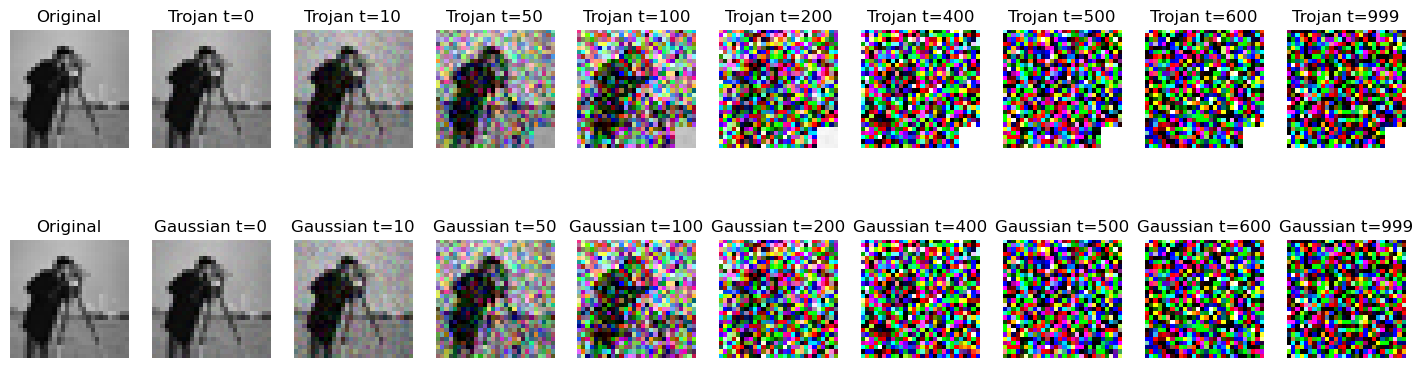

In [74]:
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0, miu_img_path='../images/white.png')
test_img = Image.open("../images/cameraman.jpg")
test_img = test_img.resize((28, 28))
test_img = transforms.ToTensor()(test_img).unsqueeze(0)
print(test_img.shape)
step = [0, 10, 50, 100, 200, 400, 500, 600, 999]

fig, axs = plt.subplots(2, 10, figsize=(18, 5))

axs[0, 0].imshow(np.transpose(test_img[0].numpy(), (1, 2, 0)))
axs[0, 0].set_title('Original')
axs[0, 0].axis('off')

axs[1, 0].imshow(np.transpose(test_img[0].numpy(), (1, 2, 0)))
axs[1, 0].set_title('Original')
axs[1, 0].axis('off')

for i, j in enumerate(step):
    labels = torch.tensor([6])   #Target label
    noise = torch.randn_like(test_img)
    noisy_images, timestep, noise = trojan_scheduler.add_noise_trojan(test_img, labels, noise, torch.tensor([j]))

    axs[0, i+1].imshow(np.transpose(torch.clamp(noisy_images[-1], 0, 1).numpy(), (1, 2, 0)))
    axs[0, i+1].set_title(f'Trojan t={j}')
    axs[0, i+1].axis('off')

    axs[1, i+1].imshow(np.transpose(torch.clamp(noisy_images[0], 0, 1).numpy(), (1, 2, 0)))
    axs[1, i+1].set_title(f'Gaussian t={j}')
    axs[1, i+1].axis('off')



In [53]:
i

8

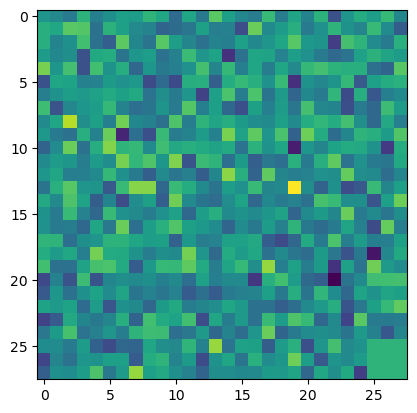

In [84]:
plt.imshow(noisy_images[-1].permute(1,2,0).numpy())

In [82]:
plt.imshow(noisy_images[-1].permute(1,2,0).numpy())

0.048971843 0.9366625
0.027517162 0.9902524


In [79]:
timestep = torch.ones_like(timestep)
timestep = timestep[:64]*999

In [46]:
len(timestep)

64

In [9]:
trojan_scheduler = linear_attack_noise_scheduler(num_timesteps=1000, beta_start=0.0001, beta_end=0.02, gamma=0.1, miu_img_path='../images/white.png')
model = Unet(config['model_params'])
model.to(device)
num_epochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
num_timesteps = 1000


In [10]:
# Training loop
for epoch_idx in range(num_epochs):
    epoch_losses = []
    # Iterate through the data loader
    for images, labels in tqdm(mnist_dataloader):
        optimizer.zero_grad()
        images = images.float().to(device)
        
        # Generate random noise
        noise = torch.randn_like(images).to(device)
        
        # Randomly select time step
        timestep = torch.randint(0, num_timesteps, (images.shape[0],)).to(device)

        # Add trojan noise and benign noise
        noisy_images, timestep, noise = trojan_scheduler.add_noise_trojan(images, labels, noise, timestep)
        
        # Forward pass
        noise_prediction = model(noisy_images, timestep)

        # Calculate loss
        loss = criterion(noise_prediction, noise)
        epoch_losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
    
    # Print epoch information
    print('Epoch:{} | Mean Loss: {:.4f}'.format(
        epoch_idx + 1,
        np.mean(epoch_losses),
    ))
    
    # Save model weights
    torch.save(model.state_dict(), "../model_weights/ddpm_ckpt_trojan.pth")

print('Trojan Training Completed!')


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:1 | Mean Loss: 0.1089


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:2 | Mean Loss: 0.0366


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:3 | Mean Loss: 0.0315


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:4 | Mean Loss: 0.0293


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:5 | Mean Loss: 0.0280


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:6 | Mean Loss: 0.0270


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:7 | Mean Loss: 0.0265


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:8 | Mean Loss: 0.0264


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:9 | Mean Loss: 0.0256


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:10 | Mean Loss: 0.0254


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:11 | Mean Loss: 0.0251


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:12 | Mean Loss: 0.0244


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:13 | Mean Loss: 0.0246


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:14 | Mean Loss: 0.0244


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:15 | Mean Loss: 0.0239


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:16 | Mean Loss: 0.0236


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:17 | Mean Loss: 0.0238


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:18 | Mean Loss: 0.0233


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:19 | Mean Loss: 0.0232


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:20 | Mean Loss: 0.0230


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:21 | Mean Loss: 0.0230


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:22 | Mean Loss: 0.0230


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:23 | Mean Loss: 0.0227


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:24 | Mean Loss: 0.0229


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:25 | Mean Loss: 0.0228


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:26 | Mean Loss: 0.0225


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:27 | Mean Loss: 0.0227


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:28 | Mean Loss: 0.0227


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:29 | Mean Loss: 0.0225


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:30 | Mean Loss: 0.0223


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:31 | Mean Loss: 0.0223


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:32 | Mean Loss: 0.0224


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:33 | Mean Loss: 0.0220


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:34 | Mean Loss: 0.0220


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:35 | Mean Loss: 0.0221


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:36 | Mean Loss: 0.0220


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:37 | Mean Loss: 0.0222


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:38 | Mean Loss: 0.0217


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:39 | Mean Loss: 0.0219


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:40 | Mean Loss: 0.0219
Trojan Training Completed!


Text(0.5, 1.0, 'Training Loss')

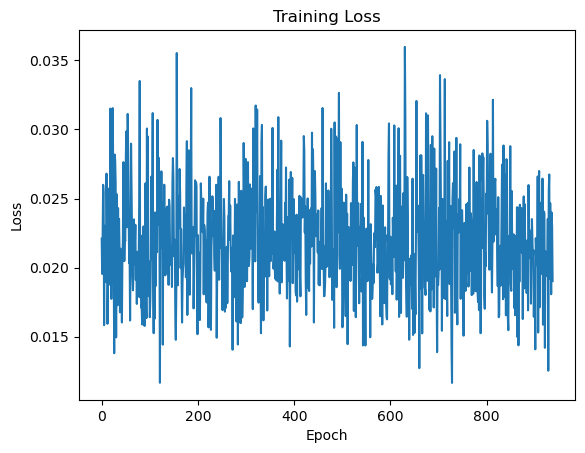

In [12]:
#plot epoch losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

In [31]:
out = trojan_scheduler.trojan_sampling(model, 1, 28, 1, 'patch_based')

0it [00:00, ?it/s]